In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
df = pd.read_csv("azurefunctions-accesses-2020.csv.bz2")
df["Datetime"] = pd.to_datetime(df["Timestamp"], unit='ms')
df = df.sort_values(by="Datetime").reset_index(drop=True)

In [3]:
df

,Timestamp,AnonRegion,AnonUserId,AnonAppName,AnonFunctionInvocationId,AnonBlobName,BlobType,AnonBlobETag,BlobBytes,Read,Write,Datetime
0,1606089600031,ayi,1169325562,56t9rffh,543816150,kk682v14oinpjr7x,BlockBlob/application/octet-stream,oic3b9iw15,3662.0,True,False,2020-11-23 00:00:00.031
1,1606089600044,ayi,1051009521,fmrflaav,417350701,q9ko56ayrq22tpkp,BlockBlob/application/octet-stream,r5b2p0ahj4,17.0,True,False,2020-11-23 00:00:00.044
2,1606089600050,dk4,2079865255,0insggn2,1767119423,m6iuvfrjacfkvjkd,BlockBlob/,88bd411wng,63.0,False,True,2020-11-23 00:00:00.050
3,1606089600052,49e,1898675568,eqi52vch,1087726192,rrdpjgw3akea4fhu,BlockBlob/application/octet-stream,h55hq7mn8h,22.0,True,False,2020-11-23 00:00:00.052
4,1606089600070,ayi,1051009521,fmrflaav,417350701,q9ko56ayrq22tpkp,BlockBlob/application/octet-stream,08xemjlhn6,17.0,False,True,2020-11-23 00:00:00.070
...,...,...,...,...,...,...,...,...,...,...,...,...
44282907,1607299199408,dk4,183053948,ip3wq7th,1503294061,cs03mdqyerxu2r4e,BlockBlob/application/json,abkxv5lam0,185717.0,True,False,2020-12-06 23:59:59.408
44282908,1607299199448,ayi,1552260191,w9jq88qw,1734492024,u2c3deou8k8nsini,BlockBlob/text/plain; charset=utf-8,cn0nnjgsg6,1392.0,True,False,2020-12-06 23:59:59.448
44282909,1607299199448,ayi,1552260191,w9jq88qw,1734492024,uw6do9o8kp47xgsf,BlockBlob/text/plain; charset=utf-8,6kyruclexp,121558.0,True,False,2020-12-06 23:59:59.448
44282910,1607299199717,ayi,1547161858,owenxtto,1167566687,pnm4q94s3qeanqfc,BlockBlob/application/octet-stream,ve6766f4o8,1358.0,True,False,2020-12-06 23:59:59.717


In [4]:
def bytes2human(n, str_format="%(value).2f%(symbol)s"):
    """Convert the bytes into a human readable format.
    """
    symbols = ('B', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB', 'ZB', 'YB')
    prefix = {}
    for i, s in enumerate(symbols[1:]):
        prefix[s] = 1 << (i+1)*10
    for symbol in reversed(symbols[1:]):
        if n >= prefix[symbol]:
            value = float(n) / prefix[symbol]
            return str_format % locals()
    return str_format % dict(symbol=symbols[0], value=n)

In [5]:
def byte_fmt(tick_val, pos):
    """This should just call bytes2human but there are issues with locals().
    """
    n = tick_val
    str_format = "%(value)i%(symbol)s"
    symbols = ('B', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB', 'ZB', 'YB')
    prefix = {}
    for i, s in enumerate(symbols[1:]):
        prefix[s] = 1 << (i+1)*10
    for symbol in reversed(symbols[1:]):
        if n >= prefix[symbol]:
            value = float(n) / prefix[symbol]
            return str_format % locals()
    return str_format % dict(symbol=symbols[0], value=n)

In [6]:
def large_number_fmt(tick_val, pos):
    """Transform a large number into a plot friendly format.
    This should be a nice loop but not in the mood for coding interviews.
    """
    if tick_val == 0:
        return '0'
    elif tick_val == 1E-5:
        return r'$10^{-5}$'
    elif tick_val == 1E-4:
        return r'$10^{-4}$'
    elif tick_val == 1E-3:
        return r'$10^{-3}$'
    elif tick_val == 1E-2:
        return '0.01'
    elif tick_val == 0.1:
        return '0.1'
    elif tick_val == 1:
        return '1'
    elif tick_val == 10:
        return '10'
    elif tick_val == 100:
        return '100'
    elif tick_val == 1000:
        return '1K'
    elif tick_val == 10000:
        return '10K'
    elif tick_val == 100000:
        return '100K'
    elif tick_val == 1E6:
        return '1M'
    elif tick_val == 1E7:
        return '10M'
    elif tick_val == 1E8:
        return '100M'
    elif tick_val == 1E9:
        return '1B'
    return "%s" % tick_val

In [7]:
def plt_blob_sizes(df):
    """Plot the distribution of the size of the blobs.
    """
    # Plot per blob access
    # Reads
    df_read = df[df["Read"] == True]
    blob_read_bytes = df_read["BlobBytes"]
    blob_read_bytes = blob_read_bytes.dropna()
    blob_read_bytes = blob_read_bytes.sort_values()
    x_read = blob_read_bytes.values
    y_read = 100.0 * np.arange(x_read.shape[0]) / x_read.shape[0]
    plt.plot(x_read, y_read, label="Read")
    # Writes
    df_write = df[df["Write"] == True]
    blob_write_bytes = df_write["BlobBytes"]
    blob_write_bytes = blob_write_bytes.dropna()
    blob_write_bytes = blob_write_bytes.sort_values()
    x_write = blob_write_bytes.values
    y_write = 100.0 * np.arange(x_write.shape[0]) / x_write.shape[0]
    plt.plot(x_write, y_write, label="Write")
    # All
    blob_bytes = df["BlobBytes"]
    blob_bytes = blob_bytes.dropna()
    blob_bytes = blob_bytes.sort_values()
    x_all = blob_bytes.values
    y_all = 100.0 * np.arange(x_all.shape[0]) / x_all.shape[0]
    plt.plot(x_all, y_all, label="All")
    # Other elements
    plt.xscale("log")
    plt.ylabel("Blob Access CDF (%)")
    plt.xlabel("Blob size")
    plt.grid()
    plt.legend()
    # X axis
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(byte_fmt))
    plt.xticks([1, 50, 1024, 50*1024, 1024*1024, 50*1024*1024, 1024*1024*1024])
    plt.tight_layout(pad=0)
    plt.show()
    
    # Plot per blob
    df_blob_size = df[["AnonBlobETag", "BlobBytes", "Read", "Write", "AnonFunctionInvocationId"]]
    df_blob_size = df_blob_size.groupby(["AnonBlobETag", "BlobBytes", "Read", "Write"]).aggregate({
        "AnonFunctionInvocationId" : "nunique"
    })
    df_blob_size = pd.DataFrame(df_blob_size).reset_index()
    # Read
    df_blob_size_read = df_blob_size[df_blob_size["Read"] == True]["BlobBytes"].dropna().sort_values()
    x_read = df_blob_size_read.values
    y_read = 100.0 * np.arange(x_read.shape[0]) / x_read.shape[0]
    plt.plot(x_read, y_read, label="Read")
    # Write
    df_blob_size_write = df_blob_size[df_blob_size["Write"] == True]["BlobBytes"].dropna().sort_values()
    x_write = df_blob_size_write.values
    y_write = 100.0 * np.arange(x_write.shape[0]) / x_write.shape[0]
    plt.plot(x_write, y_write, label="Write")
    # All
    df_blob_size = df.groupby(["AnonBlobETag"])["BlobBytes"].max()
    df_blob_size = df_blob_size.dropna()
    df_blob_size = df_blob_size.sort_values()
    x_all = df_blob_size.values
    y_all = 100.0 * np.arange(x_all.shape[0]) / x_all.shape[0]    
    plt.plot(x_all, y_all, label="All")
    # Other elements
    plt.xscale("log")
    plt.ylabel("Blob CDF (%)")
    plt.xlabel("Blob size")
    plt.grid()
    plt.legend()
    # X axis
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(byte_fmt))
    plt.xticks([1, 50, 1024, 50*1024, 1024*1024, 50*1024*1024, 1024*1024*1024])
    plt.tight_layout(pad=0)
    plt.show()
    
    # Output relevant values
    for percentile in [0, 1, 5, 10, 20, 25, 50, 75, 80, 90, 95, 99, 100]:
        if percentile <= 0:
            v = x_all[0]
        elif percentile >= 100:
            v = x_all[-1]
        else:
            v = x_all[y_all >= percentile][0]
        print("%dth: %d %s" % (percentile, v, bytes2human(v)))

In [8]:
def plt_avg_invoc_per_blob_per_app(df):
    """Plot the distribution of invocations per blobs.
    """
    df_apps_blobs = df[["AnonAppName", "AnonBlobETag", "AnonFunctionInvocationId"]]
    df_apps_blobs = df_apps_blobs.groupby("AnonAppName").aggregate({
        "AnonBlobETag" : "nunique",
        "AnonFunctionInvocationId" : "nunique"
    })
    # Invoc/Blob
    avg_invoc_per_blob_per_app = df_apps_blobs["AnonFunctionInvocationId"] / df_apps_blobs["AnonBlobETag"]
    x_ratio = avg_invoc_per_blob_per_app.sort_values().values
    y_ratio = 100.0 * np.arange(x_ratio.shape[0]) / x_ratio.shape[0]
    plt.plot(x_ratio, y_ratio, label="Invocations/Blob")
    # Invoc
    x_invoc = df_apps_blobs["AnonFunctionInvocationId"].sort_values().values
    y_invoc = 100.0 * np.arange(x_invoc.shape[0]) / x_invoc.shape[0]
    plt.plot(x_invoc, y_invoc, label="Invocations")
    # Blob
    x_blob = df_apps_blobs["AnonBlobETag"].sort_values().values
    y_blob = 100.0 * np.arange(x_blob.shape[0]) / x_blob.shape[0]
    plt.plot(x_blob, y_blob, label="Blobs")
    # plots
    plt.ylabel("Apps CDF (%)")
    plt.xlabel("")
    plt.xscale("log")
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(large_number_fmt))
    plt.xticks([0.01, 0.1, 1, 10, 100, 1000, 1E4, 1E5, 1E6, 1E7])
    plt.grid()
    plt.legend()
    plt.tight_layout(pad=0)
    plt.show()
    
    # Important values
    print("Invocations per blob")
    print(" <1: %.2f%%" % (y_ratio[x_ratio < 1][-1]))
    print(" <=1: %.2f%%" % (y_ratio[x_ratio <= 1][-1]))
    print(" <=1.1: %.2f%%" % (y_ratio[x_ratio <= 1.1][-1])) # To avoid rounding
    print(" <=100: %.2f%%" % (y_ratio[x_ratio <= 100][-1]))
    print("Blobs")
    print(" Same blob: %.2f%%" % (y_blob[x_blob <= 1][-1]))
    print(" <=100 blobs: %.2f%%" % (y_blob[x_blob <= 100][-1]))
    print(" <=10,000 blobs: %.2f%%" % (y_blob[x_blob <= 10000][-1]))
    print(" max: %d" % (x_blob.max()))

In [9]:
def plt_iat_per_blob(df):
    """Plot the interarrival time per blob.
    """
    aux = df[["AnonBlobETag", "Timestamp"]]
    aux = aux.sort_values(by=["AnonBlobETag", "Timestamp"])
    auxshift = aux.shift(-1)
    aux["NextAnonBlobETag"] = auxshift["AnonBlobETag"]
    aux["NextTimestamp"] = auxshift["Timestamp"]
    aux = aux[aux["NextAnonBlobETag"] == aux["AnonBlobETag"]]
    aux["IaT"] = aux["NextTimestamp"] - aux["Timestamp"]
    aux_group = aux.groupby("AnonBlobETag").aggregate({
        "IaT" : ["min", "max", "mean", "std", "var", "count"]
    })
    aux_group = aux_group[aux_group["IaT", "count"] > 1]
    aux_group["IaT", "CoV"] = aux_group["IaT", "std"] / aux_group["IaT", "mean"]
    aux_group = aux_group.sort_values(by=("IaT", "CoV"))

    # CoV per Blob
    # std/avg is CoV, should be 0 for periodic, 1 for poisson, higher for clustered.
    x = aux_group["IaT", "CoV"].values
    y = 100.0 * np.arange(0, x.shape[0]) / x.shape[0]
    plt.plot(x, y)
    plt.axvline(1, color="red", label="CoV=1") # Line at CoV=1 for reference
    plt.grid()
    plt.xlabel("IaT CoV")
    plt.ylabel("Blobs CDF (%)")
    plt.xlim(0.0001)
    plt.xscale("log")
    plt.legend()
    plt.tight_layout(pad=0)
    plt.show()

    # Invocations vs CoV
    x = aux_group["IaT", "count"].values
    y = aux_group["IaT", "CoV"].values
    plt.scatter(x=x+1, y=y, alpha=0.2, label="Blobs")
    plt.axhline(1, color="red", label="CoV=1") # Line at CoV=1 for reference
    plt.grid()
    plt.xlabel("Number of invocations")
    plt.ylabel("IaT CoV")
    plt.xlim(1)
    plt.ylim(0.00001)
    plt.yscale("log")
    plt.yticks([1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100])
    plt.xscale("log")
    plt.xticks([1, 10, 100, 1000, 1E4, 1E5, 1E6])
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(large_number_fmt))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(large_number_fmt))
    plt.legend()
    plt.tight_layout(pad=0)
    plt.show()

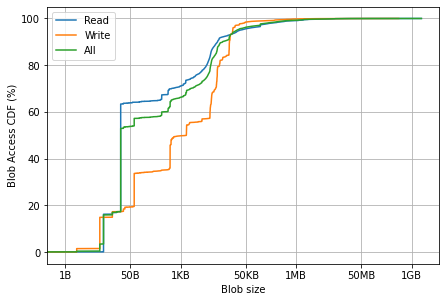

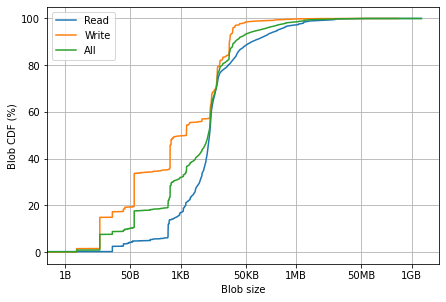

0th: 0 0.00B
1th: 8 8.00B
5th: 8 8.00B
10th: 46 46.00B
20th: 482 482.00B
25th: 542 542.00B
50th: 5302 5.18KB
75th: 9240 9.02KB
80th: 12367 12.08KB
90th: 26764 26.14KB
95th: 110611 108.02KB
99th: 1589532 1.52MB
100th: 1910124864 1.78GB


In [10]:
plt_blob_sizes(df)

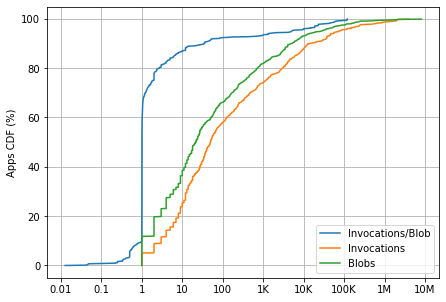

Invocations per blob
 <1: 10.98%
 <=1: 50.12%
 <=1.1: 68.11%
 <=100: 92.29%
Blobs
 Same blob: 11.80%
 <=100 blobs: 66.12%
 <=10,000 blobs: 92.99%
 max: 8137406


In [11]:
plt_avg_invoc_per_blob_per_app(df)

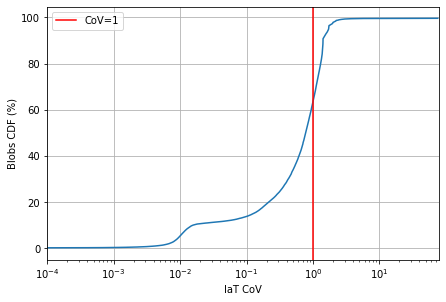

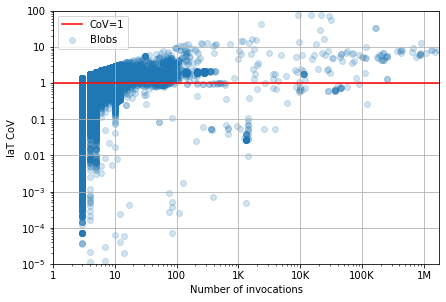

In [12]:
plt_iat_per_blob(df)